# A Generation of Enhanced Data by Variational Autoencoders and Diffusion Modeling

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
import glob
import soundfile as sf
import IPython.display as ipd
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Data Understanding and Processing

## EmoDB Dataset

The Berlin Database of Emotional Speech (EmoDB) contains emotional speech recordings from 10 actors (5 male, 5 female) in 7 different emotions:
- Anger (W - Wut)
- Boredom (L - Langeweile)
- Disgust (E - Ekel)
- Fear (A - Angst)
- Happiness (F - Freude)
- Sadness (T - Trauer)
- Neutral (N - Neutral)

The filename format is: AABCDE.wav where:
- AA: Speaker ID (03, 08, 09, 10, 11, 12, 13, 14, 15, 16)
- B: a or b (version)
- C: Two-digit sentence ID (01-10)
- D: Emotion (W, L, E, A, F, T, N)
- E: a, b, c, ... (repetition)

In [2]:
def load_emodb_data():
    """
    Load and decode the EmoDB dataset
    """
    # Define the path to the EmoDB dataset
    emodb_path = 'EmoDB/wav/'
    
    # Define emotion mapping
    emotion_map = {
        'W': 'anger',
        'L': 'boredom',
        'E': 'disgust',
        'A': 'fear',
        'F': 'happiness',
        'T': 'sadness',
        'N': 'neutral'
    }
    
    # Get all wav files
    wav_files = glob.glob(os.path.join(emodb_path, '*.wav'))
    
    # Create a list to store data
    data = []
    
    # Process each file
    for wav_file in tqdm(wav_files, desc='Loading EmoDB'):
        filename = os.path.basename(wav_file)
        
        # Extract information from filename
        speaker_id = filename[:2]
        version = filename[2]
        sentence_id = filename[3:5]
        emotion_code = filename[5]
        repetition = filename[6]
        
        # Map emotion code to emotion name
        emotion = emotion_map.get(emotion_code, 'unknown')
        
        # Load audio file
        y, sr = librosa.load(wav_file, sr=None)
        
        # Store data
        data.append({
            'filename': filename,
            'path': wav_file,
            'speaker_id': speaker_id,
            'version': version,
            'sentence_id': sentence_id,
            'emotion': emotion,
            'emotion_code': emotion_code,
            'repetition': repetition,
            'audio': y,
            'sr': sr,
            'duration': len(y) / sr,
            'dataset': 'emodb'
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    print(f"Loaded {len(df)} audio files from EmoDB dataset")
    print(f"Emotions distribution:\n{df['emotion'].value_counts()}")
    print(f"Speakers distribution:\n{df['speaker_id'].value_counts()}")
    
    return df

In [3]:
# Load EmoDB dataset
emodb_df = load_emodb_data()

Loading EmoDB: 100%|██████████| 535/535 [00:05<00:00, 100.36it/s]


Loaded 535 audio files from EmoDB dataset
Emotions distribution:
emotion
anger        127
boredom       81
neutral       79
happiness     71
fear          69
sadness       62
disgust       46
Name: count, dtype: int64
Speakers distribution:
speaker_id
16    71
14    69
13    61
08    58
15    56
11    55
03    49
09    43
10    38
12    35
Name: count, dtype: int64


## RAVDESS Dataset

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains emotional speech recordings from 24 professional actors (12 male, 12 female) in 8 different emotions.

The filename format is: XX-YY-ZZ-AA-BB-CC-DD.wav where:
- XX: Modality (01 = full-AV, 02 = video-only, 03 = audio-only)
- YY: Vocal channel (01 = speech, 02 = song)
- ZZ: Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
- AA: Emotional intensity (01 = normal, 02 = strong)
- BB: Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door")
- CC: Repetition (01 = 1st repetition, 02 = 2nd repetition)
- DD: Actor (01 to 24. Odd numbered actors are male, even numbered actors are female)

In [4]:
def load_ravdess_data():
    """
    Load and decode the RAVDESS dataset
    """
    # Define the path to the RAVDESS dataset
    ravdess_path = 'RAVDESS/'
    
    # Define emotion mapping
    emotion_map = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }
    
    # Define intensity mapping
    intensity_map = {
        '01': 'normal',
        '02': 'strong'
    }
    
    # Define statement mapping
    statement_map = {
        '01': 'Kids are talking by the door',
        '02': 'Dogs are sitting by the door'
    }
    
    # Get all actor directories
    actor_dirs = [d for d in os.listdir(ravdess_path) if d.startswith('Actor_')]
    
    # Create a list to store data
    data = []
    
    # Process each actor directory
    for actor_dir in tqdm(actor_dirs, desc='Loading RAVDESS'):
        actor_path = os.path.join(ravdess_path, actor_dir)
        
        # Get all wav files for this actor
        wav_files = glob.glob(os.path.join(actor_path, '*.wav'))
        
        # Process each file
        for wav_file in wav_files:
            filename = os.path.basename(wav_file)
            parts = filename.split('-')
            
            # Skip if not enough parts
            if len(parts) < 7:
                continue
                
            # Extract information from filename
            modality = parts[0]  # 03 = audio-only
            vocal_channel = parts[1]  # 01 = speech
            emotion_code = parts[2]
            intensity = parts[3]
            statement = parts[4]
            repetition = parts[5]
            actor_id = parts[6].split('.')[0]  # Remove .wav extension
            
            # Skip if not audio-only speech
            if modality != '03' or vocal_channel != '01':
                continue
                
            # Map codes to descriptions
            emotion = emotion_map.get(emotion_code, 'unknown')
            intensity_desc = intensity_map.get(intensity, 'unknown')
            statement_desc = statement_map.get(statement, 'unknown')
            
            # Determine gender (odd actor_id = male, even = female)
            gender = 'male' if int(actor_id) % 2 == 1 else 'female'
            
            # Load audio file
            y, sr = librosa.load(wav_file, sr=None)
            
            # Store data
            data.append({
                'filename': filename,
                'path': wav_file,
                'actor_id': actor_id,
                'gender': gender,
                'emotion': emotion,
                'emotion_code': emotion_code,
                'intensity': intensity_desc,
                'statement': statement_desc,
                'repetition': repetition,
                'audio': y,
                'sr': sr,
                'duration': len(y) / sr,
                'dataset': 'ravdess'
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    print(f"Loaded {len(df)} audio files from RAVDESS dataset")
    print(f"Emotions distribution:\n{df['emotion'].value_counts()}")
    print(f"Gender distribution:\n{df['gender'].value_counts()}")
    
    return df

In [5]:
# Load RAVDESS dataset
ravdess_df = load_ravdess_data()

Loading RAVDESS: 100%|██████████| 24/24 [00:02<00:00,  8.00it/s]

Loaded 1440 audio files from RAVDESS dataset
Emotions distribution:
emotion
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64
Gender distribution:
gender
male      720
female    720
Name: count, dtype: int64


## Data Visualization and Analysis

In [6]:
# Function to visualize audio waveform and spectrogram
def visualize_audio(audio, sr, title=None):
    plt.figure(figsize=(14, 5))
    
    # Plot waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Plot spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    
    if title:
        plt.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Function to play audio
def play_audio(audio, sr, title=None):
    if title:
        print(title)
    return ipd.Audio(audio, rate=sr)

### EmoDB Examples

Emotion: happiness
Speaker ID: 10
Filename: 10a02Fa.wav
Duration: 1.52 seconds


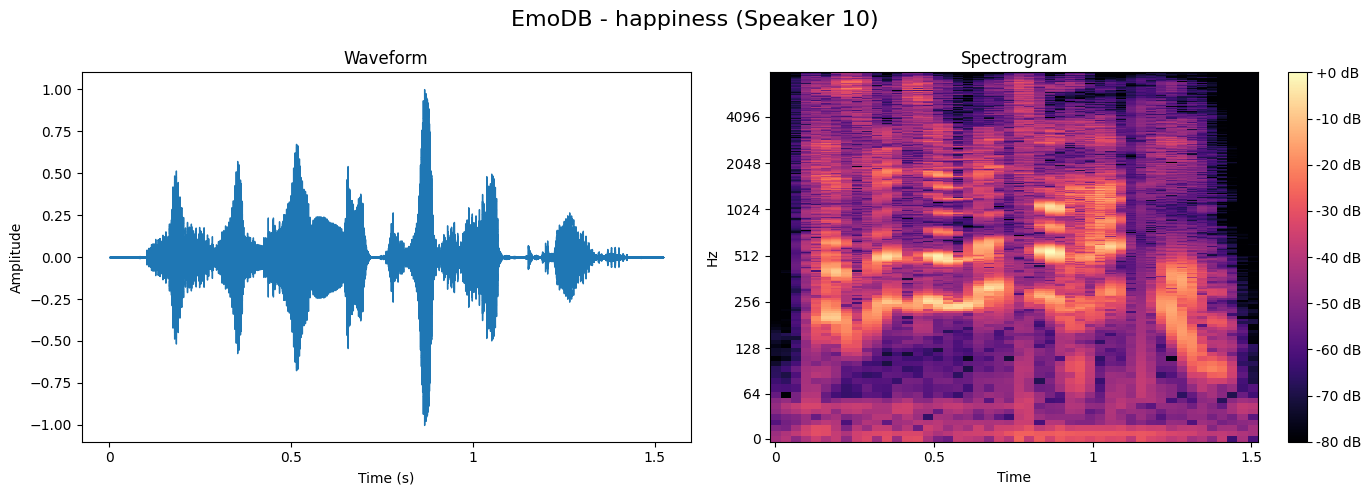


--------------------------------------------------

Emotion: neutral
Speaker ID: 09
Filename: 09a07Na.wav
Duration: 1.84 seconds


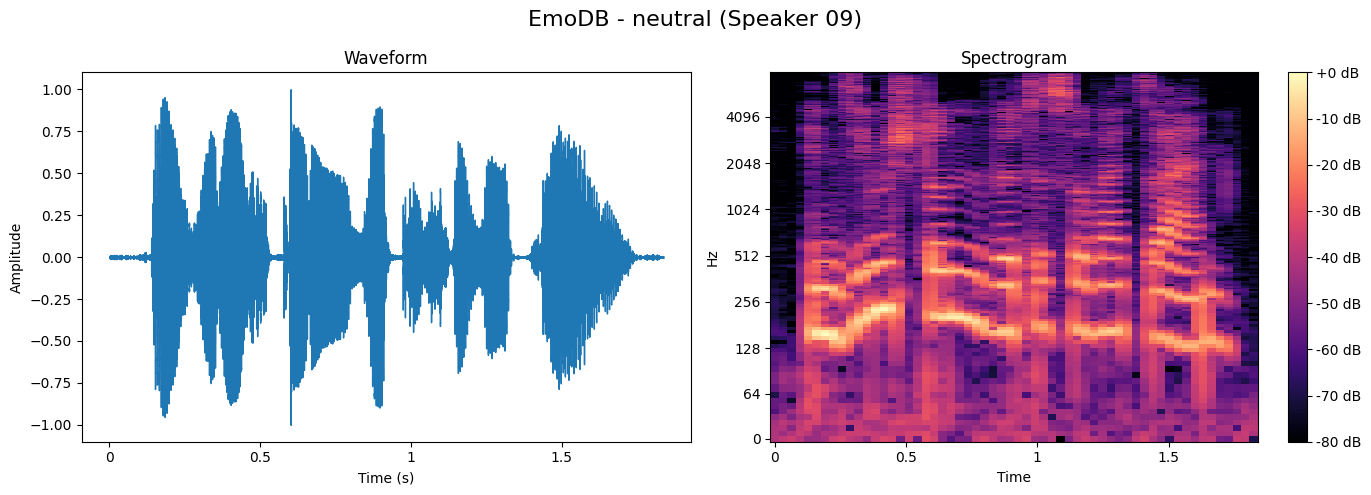


--------------------------------------------------



In [7]:
# Display examples from EmoDB for each emotion
emotions = emodb_df['emotion'].unique()

for emotion in emotions[:2]:  # Just show a couple of examples to save space
    # Get a random sample for this emotion
    sample = emodb_df[emodb_df['emotion'] == emotion].sample(1).iloc[0]
    
    # Display information
    print(f"Emotion: {sample['emotion']}")
    print(f"Speaker ID: {sample['speaker_id']}")
    print(f"Filename: {sample['filename']}")
    print(f"Duration: {sample['duration']:.2f} seconds")
    
    # Visualize audio
    visualize_audio(sample['audio'], sample['sr'], 
                   title=f"EmoDB - {sample['emotion']} (Speaker {sample['speaker_id']})")
    
    # Play audio
    display(play_audio(sample['audio'], sample['sr']))
    
    print("\n" + "-"*50 + "\n")

### RAVDESS Examples

Emotion: neutral
Actor ID: 11 (male)
Intensity: normal
Statement: Kids are talking by the door
Filename: 03-01-01-01-01-02-11.wav
Duration: 3.10 seconds


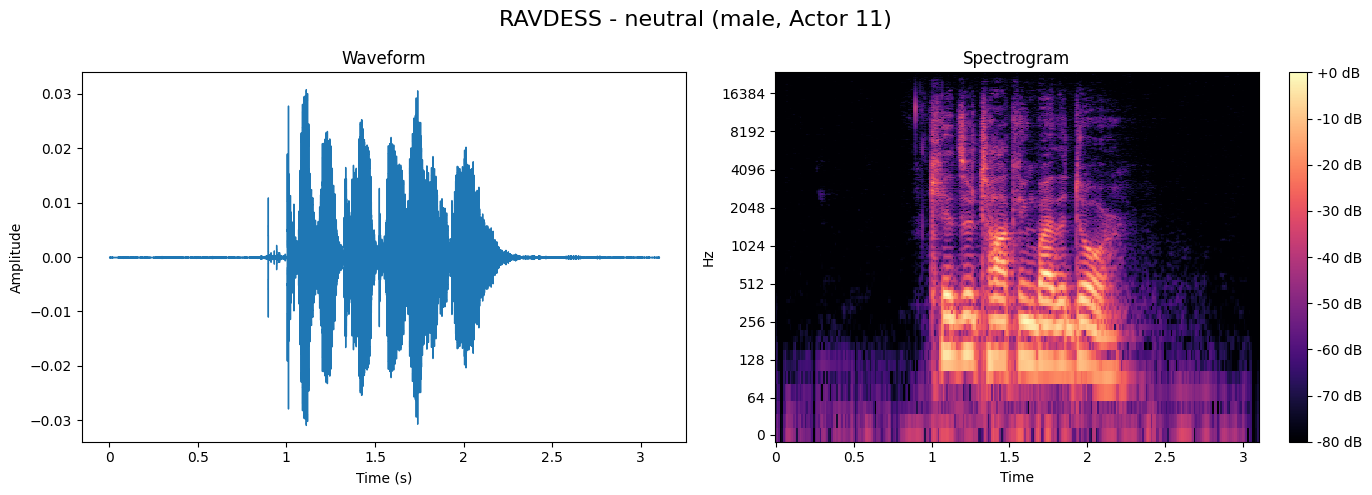


--------------------------------------------------

Emotion: calm
Actor ID: 04 (female)
Intensity: strong
Statement: Kids are talking by the door
Filename: 03-01-02-02-01-01-04.wav
Duration: 3.97 seconds


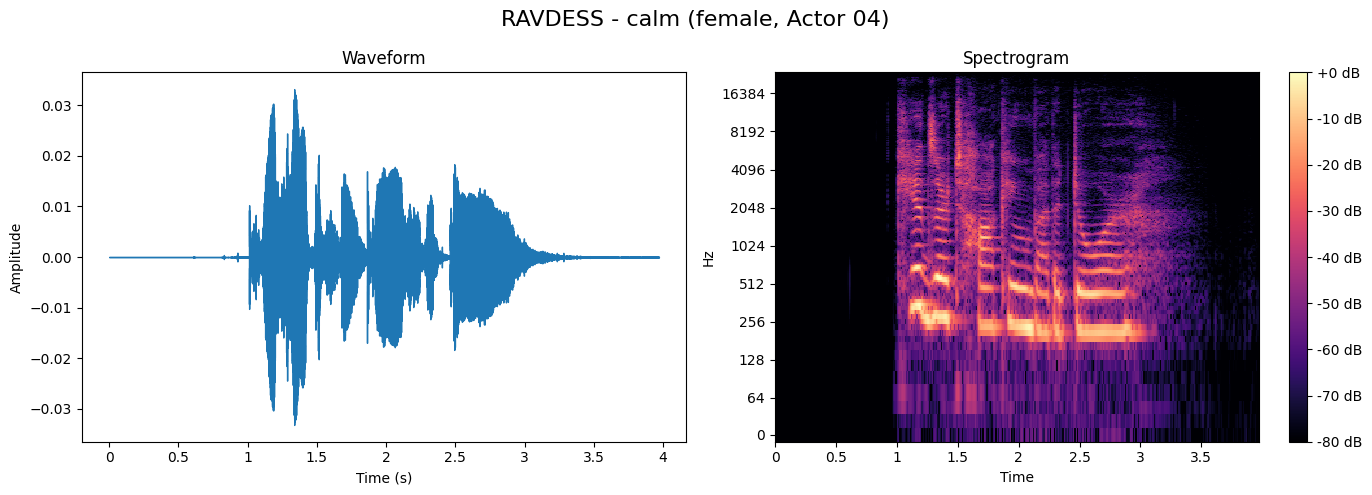


--------------------------------------------------



In [8]:
# Display examples from RAVDESS for each emotion
emotions = ravdess_df['emotion'].unique()

for emotion in emotions[:2]:  # Just show a couple of examples to save space
    # Get a random sample for this emotion
    sample = ravdess_df[ravdess_df['emotion'] == emotion].sample(1).iloc[0]
    
    # Display information
    print(f"Emotion: {sample['emotion']}")
    print(f"Actor ID: {sample['actor_id']} ({sample['gender']})")
    print(f"Intensity: {sample['intensity']}")
    print(f"Statement: {sample['statement']}")
    print(f"Filename: {sample['filename']}")
    print(f"Duration: {sample['duration']:.2f} seconds")
    
    # Visualize audio
    visualize_audio(sample['audio'], sample['sr'], 
                   title=f"RAVDESS - {sample['emotion']} ({sample['gender']}, Actor {sample['actor_id']})")
    
    # Play audio
    display(play_audio(sample['audio'], sample['sr']))
    
    print("\n" + "-"*50 + "\n")

## Feature Extraction and Dataset Combination

In [9]:
def extract_features(audio, sr):
    """
    Extract audio features using librosa
    """
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    
    # Extract spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    
    # Extract zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    
    # Extract chroma features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Combine features
    features = np.concatenate([
        mfccs_mean, mfccs_std,
        [np.mean(spectral_centroid), np.std(spectral_centroid)],
        [np.mean(spectral_bandwidth), np.std(spectral_bandwidth)],
        [np.mean(spectral_rolloff), np.std(spectral_rolloff)],
        [np.mean(zcr), np.std(zcr)],
        chroma_mean
    ])
    
    return features

In [10]:
def map_emotions(emotion, dataset):
    """
    Map emotions from different datasets to a common set
    """
    if dataset == 'emodb':
        mapping = {
            'anger': 'angry',
            'happiness': 'happy',
            'fear': 'fearful',
            'sadness': 'sad',
            'disgust': 'disgust',
            'boredom': 'neutral',  
            'neutral': 'neutral'
        }
    else:  # ravdess
        mapping = {
            'angry': 'angry',
            'happy': 'happy',
            'fearful': 'fearful',
            'sad': 'sad',
            'disgust': 'disgust',
            'neutral': 'neutral'
        }
    
    return mapping.get(emotion, 'unknown')

In [11]:
def combine_datasets(emodb_df, ravdess_df):
    """
    Combine EmoDB and RAVDESS datasets
    """
    # Create copies to avoid modifying original dataframes
    emodb = emodb_df.copy()
    ravdess = ravdess_df.copy()
    
    # Map emotions to common set
    emodb['emotion_common'] = emodb.apply(lambda row: map_emotions(row['emotion'], 'emodb'), axis=1)
    ravdess['emotion_common'] = ravdess.apply(lambda row: map_emotions(row['emotion'], 'ravdess'), axis=1)
    
    # Extract features
    print("Extracting features from EmoDB...")
    emodb['features'] = emodb.apply(lambda row: extract_features(row['audio'], row['sr']), axis=1)
    
    print("Extracting features from RAVDESS...")
    ravdess['features'] = ravdess.apply(lambda row: extract_features(row['audio'], row['sr']), axis=1)
    
    # Combine datasets
    combined_df = pd.concat([emodb, ravdess], ignore_index=True)
    
    print(f"Combined dataset size: {len(combined_df)} samples")
    print(f"Common emotions distribution:\n{combined_df['emotion_common'].value_counts()}")
    
    return combined_df

In [12]:
# Combine datasets
combined_df = combine_datasets(emodb_df, ravdess_df)

Extracting features from EmoDB...
Extracting features from RAVDESS...
Combined dataset size: 1975 samples
Common emotions distribution:
emotion_common
unknown    384
angry      319
happy      263
fearful    261
neutral    256
sad        254
disgust    238
Name: count, dtype: int64


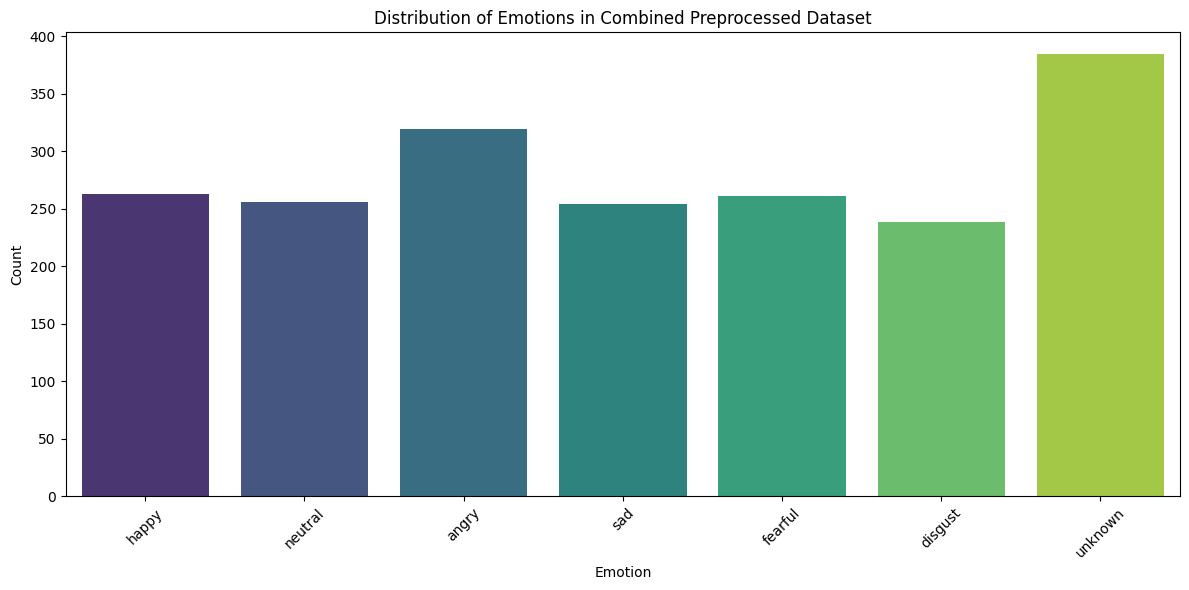

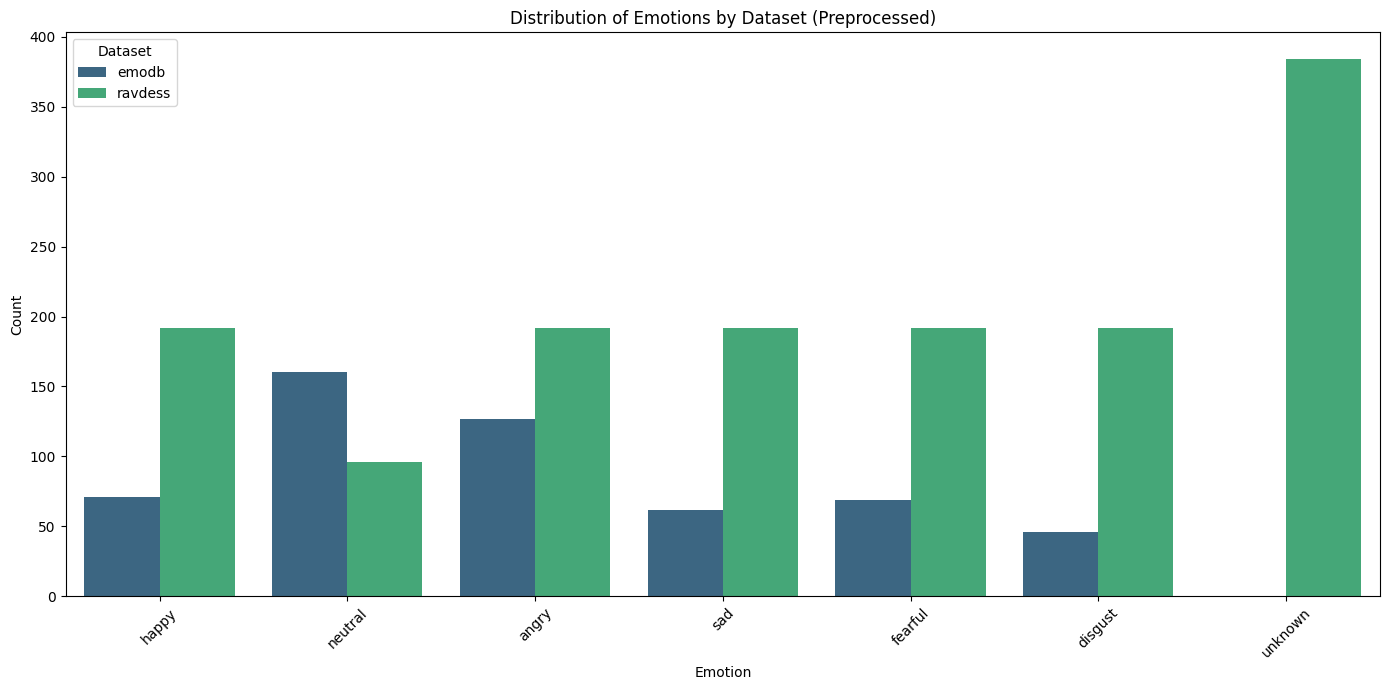

In [21]:
# Visualize the distribution of emotions in the combined preprocessed dataset
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_common', data=combined_processed_df, palette='viridis')
plt.title('Distribution of Emotions in Combined Preprocessed Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize the distribution of emotions by dataset
plt.figure(figsize=(14, 7))
sns.countplot(x='emotion_common', hue='dataset', data=combined_processed_df, palette='viridis')
plt.title('Distribution of Emotions by Dataset (Preprocessed)')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

## Audio Preprocessing: Padding and Resampling

After combining the datasets, we need to standardize the audio files by:
1. Padding shorter samples to match a uniform length of 10 seconds
2. Resampling all audio to 22,025 Hz for uniformity

In [13]:
def pad_and_resample_audio(audio, sr, target_sr=22050, target_length=10):
    """
    Pad shorter samples to match the target length and resample to target sample rate
    """
    # Resample audio to target sample rate
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    
    # Calculate target length in samples
    target_samples = target_length * target_sr
    
    # Pad audio if shorter than target length
    if len(audio) < target_samples:
        # Pad with zeros at the end
        audio = np.pad(audio, (0, target_samples - len(audio)), 'constant')
    elif len(audio) > target_samples:
        # Trim if longer than target length
        audio = audio[:target_samples]
    
    return audio, target_sr

In [16]:
# Preprocess EmoDB dataset
emodb_processed = emodb_df.copy()

print("Preprocessing EmoDB dataset...")
for i in tqdm(range(len(emodb_processed))):
    audio = emodb_processed.loc[i, 'audio']
    sr = emodb_processed.loc[i, 'sr']
    
    # Pad and resample
    processed_audio, new_sr = pad_and_resample_audio(audio, sr)
    
    # Update dataframe
    emodb_processed.at[i, 'audio'] = processed_audio
    emodb_processed.at[i, 'sr'] = new_sr
    emodb_processed.at[i, 'duration'] = len(processed_audio) / new_sr

# Preprocess RAVDESS dataset
ravdess_processed = ravdess_df.copy()

print("\nPreprocessing RAVDESS dataset...")
for i in tqdm(range(len(ravdess_processed))):
    audio = ravdess_processed.loc[i, 'audio']
    sr = ravdess_processed.loc[i, 'sr']
    
    # Pad and resample
    processed_audio, new_sr = pad_and_resample_audio(audio, sr)
    
    # Update dataframe
    ravdess_processed.at[i, 'audio'] = processed_audio
    ravdess_processed.at[i, 'sr'] = new_sr
    ravdess_processed.at[i, 'duration'] = len(processed_audio) / new_sr

print(f"\nEmoDB: {len(emodb_processed)} samples processed")
print(f"Sample rate: {emodb_processed['sr'].iloc[0]} Hz")
print(f"Duration: {emodb_processed['duration'].iloc[0]} seconds")

print(f"\nRAVDESS: {len(ravdess_processed)} samples processed")
print(f"Sample rate: {ravdess_processed['sr'].iloc[0]} Hz")
print(f"Duration: {ravdess_processed['duration'].iloc[0]} seconds")

Preprocessing EmoDB dataset...


100%|██████████| 535/535 [00:01<00:00, 497.16it/s]



Preprocessing RAVDESS dataset...


100%|██████████| 1440/1440 [00:03<00:00, 386.55it/s]


EmoDB: 535 samples processed
Sample rate: 22050 Hz
Duration: 10.0 seconds

RAVDESS: 1440 samples processed
Sample rate: 22050 Hz
Duration: 10.0 seconds


In [ ]:
# Extract features from preprocessed EmoDB dataset
print("Extracting features from preprocessed EmoDB dataset...")
emodb_processed['features'] = emodb_processed.apply(lambda row: extract_features(row['audio'], row['sr']), axis=1)

# Extract features from preprocessed RAVDESS dataset
print("\nExtracting features from preprocessed RAVDESS dataset...")
ravdess_processed['features'] = ravdess_processed.apply(lambda row: extract_features(row['audio'], row['sr']), axis=1)

print(f"\nExtracted features from {len(emodb_processed)} EmoDB samples")
print(f"Extracted features from {len(ravdess_processed)} RAVDESS samples")

Extracting features from preprocessed EmoDB dataset...

Extracting features from preprocessed RAVDESS dataset...

Extracted features from 535 EmoDB samples
Extracted features from 1440 RAVDESS samples


In [15]:
# Map emotions for preprocessed EmoDB dataset
emodb_processed['emotion_common'] = emodb_processed.apply(lambda row: map_emotions(row['emotion'], 'emodb'), axis=1)

# Map emotions for preprocessed RAVDESS dataset
ravdess_processed['emotion_common'] = ravdess_processed.apply(lambda row: map_emotions(row['emotion'], 'ravdess'), axis=1)

# Combine preprocessed datasets
combined_processed_df = pd.concat([emodb_processed, ravdess_processed], ignore_index=True)

print(f"Combined preprocessed dataset size: {len(combined_processed_df)} samples")
print(f"Common emotions distribution:\n{combined_processed_df['emotion_common'].value_counts()}")

Combined preprocessed dataset size: 1975 samples
Common emotions distribution:
emotion_common
unknown    384
angry      319
happy      263
fearful    261
neutral    256
sad        254
disgust    238
Name: count, dtype: int64


## Feature Extraction: Mel-Spectrograms

Now that we have preprocessed our audio data, we can extract features for model training. Mel-spectrograms are a popular feature representation for audio classification tasks, especially for emotion recognition.

In [ ]:
def extract_mel_spectrogram(audio, sr=22050, n_fft=1024, hop_length=256, n_mels=128):
    """
    Extract mel-spectrogram features from audio data.
    """
    # Extract mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_fft=n_fft, 
        hop_length=hop_length,
        n_mels=n_mels
    )
    
    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Z-score normalization (standardize the values)
    S_dB_normalized = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / np.std(log_mel_spectrogram)

    # Plot the mel-spectrogram
    librosa.display.specshow(S_dB_normalized, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Normalized Mel-Spectrogram')
    plt.show()
    
    return log_mel_spectrogram

In [31]:
def extract_features_from_dataset(df):
    """
    Extract mel-spectrogram features from all audio files in the dataset.
    """
    features = []
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Extracting mel-spectrograms"):
        audio, sr = librosa.load(row['path'], sr=22050)
        mel_spec = extract_mel_spectrogram(audio, sr=sr)
        features.append(mel_spec)
    
    return features

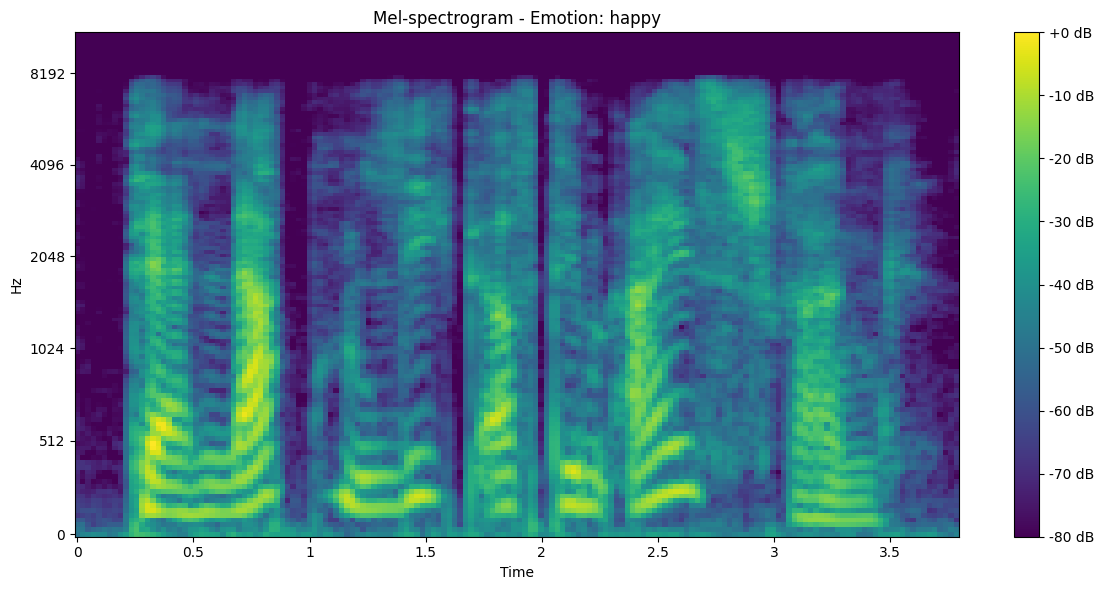

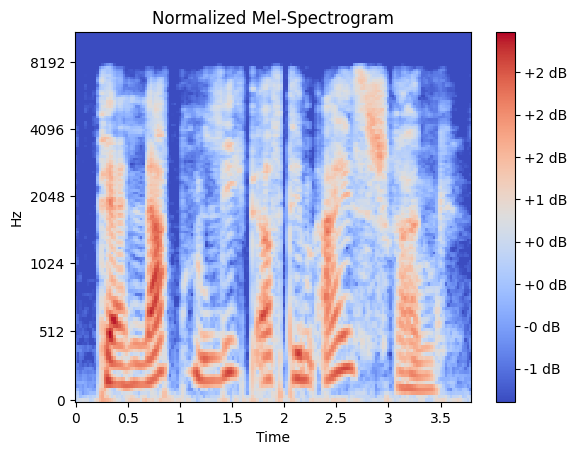

In [33]:
# Extract and visualize a mel-spectrogram for a sample audio file
sample_idx = 0  
sample_path = combined_processed_df.iloc[sample_idx]['path']
sample_emotion = combined_processed_df.iloc[sample_idx]['emotion_common']

# Load audio
audio, sr = librosa.load(sample_path, sr=22050)

# Plot
plt.figure(figsize=(12, 6))
librosa.display.specshow(
    mel_spec, 
    sr=sr, 
    x_axis='time', 
    y_axis='mel', 
    hop_length=512,
    cmap='viridis'
)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-spectrogram - Emotion: {sample_emotion}')
plt.tight_layout()
plt.show()

# Extract mel-spectrogram
mel_spec = extract_mel_spectrogram(audio, sr=sr)



## Batch Processing

Now we can extract mel-spectrograms for all audio files in our dataset. This may take some time depending on the size of the dataset.

In [ ]:
# Extract features for all audio files
# mel_features = extract_features_from_dataset(combined_processed_df)

# For demonstration, let's extract features for a small subset
subset_size = min(50, len(combined_processed_df)) 
subset_df = combined_processed_df.iloc[:subset_size]
mel_features_subset = extract_features_from_dataset(subset_df)

print(f"Extracted {len(mel_features_subset)} mel-spectrograms")
print(f"Feature shape: {mel_features_subset[0].shape}")

Extracting mel-spectrograms: 100%|██████████| 50/50 [00:00<00:00, 106.47it/s]

Extracted 50 mel-spectrograms
Feature shape: (128, 82)


## Save Features

We can save the extracted features to disk for later use in model training.

In [ ]:
# Create directory for saving features if it doesn't exist
features_dir = "features"
os.makedirs(features_dir, exist_ok=True)

# Save the subset of features
np.save(os.path.join(features_dir, "mel_features_subset.npy"), np.array(mel_features_subset))
subset_df.reset_index(drop=True).to_csv(os.path.join(features_dir, "subset_metadata.csv"), index=False)

print(f"Features saved to {features_dir}/mel_features_subset.npy")
print(f"Metadata saved to {features_dir}/subset_metadata.csv")

## Emotion and Utterance Style Embedding Extraction

Now we'll extract two types of embeddings from the mel-spectrograms:
1. **Emotion embeddings** - Features that capture the emotional content
2. **Utterance style embeddings** - Features that describe how the emotion is expressed

These embeddings will be useful for later work with diffusion models.

In [26]:
# Import the embedding extraction module
import embedding_extraction as ee

# Load the saved mel-spectrogram features
features = np.load(os.path.join(features_dir, "mel_features_subset.npy"))
metadata_df = pd.read_csv(os.path.join(features_dir, "subset_metadata.csv"))

# Get labels
labels = metadata_df['emotion_common'].values

# Train the embedding model
print("Training embedding model...")
full_model, emotion_encoder, style_encoder, history, X_train, X_test, y_train, y_test, label_encoder = ee.train_embedding_model(
    features, labels, emotion_dim=64, style_dim=64, epochs=20, batch_size=32
)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Extract embeddings
print("Extracting embeddings...")
emotion_embeddings, style_embeddings, all_labels = ee.extract_embeddings(
    emotion_encoder, style_encoder, X_train, X_test, y_train, y_test
)

# Visualize embeddings
print("Visualizing embeddings...")
ee.visualize_embeddings(emotion_embeddings, style_embeddings, all_labels, label_encoder)

In [ ]:
# Save embeddings and models
print("Saving embeddings and models...")
ee.save_embeddings(emotion_embeddings, style_embeddings, all_labels, X_train, X_test, label_encoder, emotion_encoder, style_encoder)

### Analysis of Emotion and Style Embeddings

The embeddings we've extracted serve different purposes:

1. **Emotion Embeddings**: These capture the emotional content of the speech. In the t-SNE visualization, we should see clear clusters corresponding to different emotions. These embeddings focus on what emotion is being expressed.

2. **Style Embeddings**: These capture how the emotion is expressed - the speaking style, prosody, rhythm, and other characteristics that are independent of the emotional content. These embeddings might show less clear emotion-based clustering and instead capture speaker-specific or utterance-specific characteristics.

For diffusion models, these separate embeddings will allow you to:
- Generate speech with specific emotional content (using emotion embeddings)
- Control the style of delivery independently (using style embeddings)
- Mix and match emotions and styles from different speakers

The separation of emotion and style is crucial for controllable generation in diffusion models.